# Cancer Classification Model - Genetic Detection 

---
embed-resources: true
echo: false
---

# I. Introduction

For my CS 307 final project, I developed a machine learning model to classify a patient’s cancer type based on genetic data.

Working with this dataset was a completely new challenge for me because each sample included ~4,000 gene-based feature variables, which is a much higher dimensional amount than any previous ML project I’ve worked on. Because of this, my goal wasn’t just to build an accurate classifier, but to figure out how much of that genetic information was actually necessary.

To accomplish this, I used a logistic regression classification model and implemented a feature reduction technique to identify the smallest set of genes that could still achieve perfect prediction accuracy on new unseen test data.

In [1]:
# basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# machine learning imports
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore", message="Features .* are constant\\.", category=UserWarning)
warnings.filterwarnings("ignore", message="invalid value encountered in divide", category=RuntimeWarning)

In [2]:
genetics = pd.read_parquet(
    "https://lab.cs307.org/genetics/data/genetics.parquet",
)

# II. Methods

### Target Variable — *cancer*:

*BRCA*: Breast Invasive Carcinoma

*PRAD*: Prostate Adenocarcinoma

*KIRC*: Kidney Renal Clear Cell Carcinoma

*LUAD*: Lung Adenocarcinoma

*COAD*: Colon Adenocarcinoma

This dataset also contains 4,000 gene-based feature variables (all numeric) that represent genetic measurements for each sample. Each gene feature was used as a potential predictor for the cancer type.

To build the cancer classification model, I first created a pipeline to preprocess the data so it could be used effectively for machine learning. Within this pipeline, the numeric gene features were scaled to standardize their ranges, and imputed where necessary to handle missing values. Since the predictors were already numeric, no encoding was needed.

After preprocessing, I trained and evaluated multiple logistic regression models. Because the dataset had a very high number of features relative to the number of samples, I decided to use feature reduction to make the model faster and more efficient. Specifically, I applied SelectKBest with an ANOVA F-test (f_classif) to select the most important genes before fitting the model.

To tune the model, I tested multiple values of k (the number of selected genes) and compared performance on unseen test data. The final model used a pipeline of preprocessing → SelectKBest → logistic regression, and I selected the smallest k value that still achieved perfect test accuracy.

In [3]:
genetics.head()

,cancer,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_3990,gene_3991,gene_3992,gene_3993,gene_3994,gene_3995,gene_3996,gene_3997,gene_3998,gene_3999
0,PRAD,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,0.000000,11.722884,11.831470,7.785282,11.877556,4.926711,0.591871,8.294230,9.086553,6.475515
1,LUAD,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,0.000000,10.406705,10.795447,8.007330,11.330637,5.041931,1.327170,6.344054,9.532814,4.216191
2,PRAD,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,0.000000,11.033850,10.292609,6.580491,11.152196,0.000000,0.000000,4.575712,10.485900,4.499029
3,PRAD,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,0.000000,11.137958,10.401871,6.259530,11.640385,3.068258,0.000000,5.421661,9.660732,6.612882
4,BRCA,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,0.360982,10.757932,9.944203,8.311430,11.275572,1.580097,0.000000,6.935271,10.425698,5.104899


In [4]:
#splitting data
train, test = train_test_split(
    genetics,
    test_size=0.20,
    random_state=42,
)

features = genetics.columns.drop("cancer")
target = "cancer"

x_train = train[features]
y_train = train[target]

x_test = test[features]
y_test = test[target]

In [5]:
#creating preprocessor
numeric_transformer = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(),
)
preprocessor = make_column_transformer(
    (numeric_transformer, features),
    remainder="drop",
)

# III. Results

To evaluate model performance fairly, the dataset was split into separate training and test sets. All preprocessing and feature selection were fit on the training data only, and the final accuracy was reported on the unseen test set to estimate how well the model generalizes.

Because the goal of this project was to correctly classify cancer type, I used accuracy as the main evaluation metric (along with a confusion matrix to confirm performance across all five classes).

I tested multiple values of k in SelectKBest to see how many genes were actually needed to achieve strong performance. The results are shown below:

In [6]:
#testing models with different amounts of features
test_acc = []
param_grid = [1,5,10,20,50]

for k in param_grid:
    mod_k = make_pipeline(
        preprocessor,        
        SelectKBest(f_classif, k=k),
        LogisticRegression(solver="lbfgs", max_iter=2000)
    )
    mod_k.fit(x_train, y_train)
    pred = mod_k.predict(x_test)
    test_acc.append(accuracy_score(y_test, pred))

results = pd.DataFrame(
    {
        "num features": param_grid,
        "accuracy": test_acc,
    }
)
results.head(5)

,num features,accuracy
0,1,0.527950
1,5,0.844720
2,10,0.944099
3,20,0.968944
4,50,1.000000


These results show that performance improved quickly as more gene features were included, and the model reached perfect test accuracy with only 50 selected genes. The final selected model was the smallest feature set that still achieved 100% accuracy, and the confusion matrix confirmed that every test sample was classified correctly.

In [7]:
#picking the best model
mod = make_pipeline(
        preprocessor,        
        SelectKBest(f_classif, k=50),
        LogisticRegression(solver="lbfgs", max_iter=2000)
    )
mod.fit(x_train, y_train)
pred = mod.predict(x_test)

acc = accuracy_score(y_test, pred)

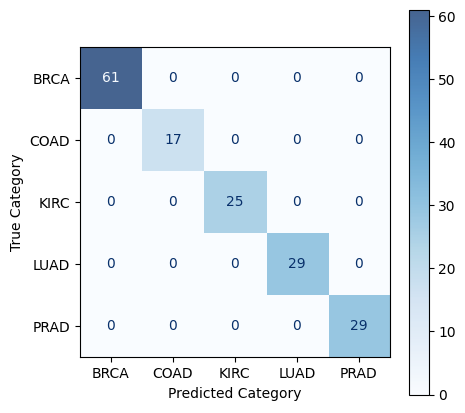

In [8]:
#confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    pred,
    ax=ax,
    im_kw={"cmap": "Blues", "alpha": 0.75}
)
ax.set_xlabel("Predicted Category")
ax.set_ylabel("True Category")
ax.grid(False)
plt.show()

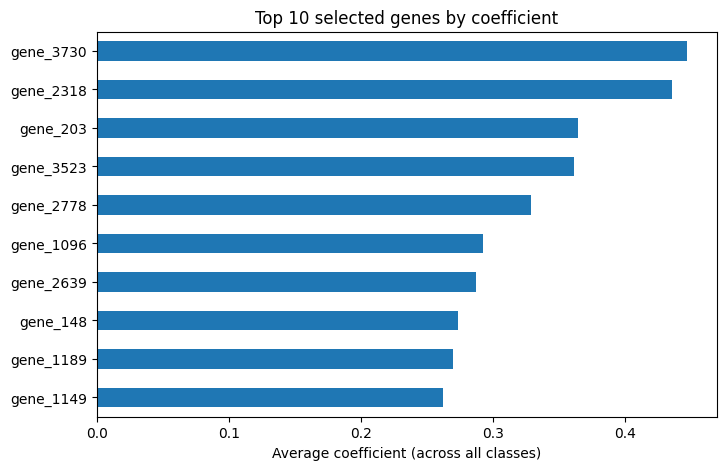

In [9]:
#top 10 genes by coefficient
X_cols = genetics.columns.drop("cancer")
selector = mod.named_steps["selectkbest"]
clf = mod.named_steps["logisticregression"]
selected = X_cols[selector.get_support()]
coef = clf.coef_  
imp = pd.Series(np.mean(np.abs(coef), axis=0), index=selected).sort_values(ascending=False)

imp.head(10).iloc[::-1].plot(kind="barh", figsize=(8,5))
plt.title("Top 10 selected genes by coefficient")
plt.xlabel("Average coefficient (across all classes)")
plt.show()

# IV. Principal Component Analysis 

The PCA visual is a 2D projection of the full gene-feature space, where each point represents a sample and the colors represent the true cancer type. Even after reducing ~4,000 gene features down to just two components, we can see several visibly seperate clusters. Overall, this visual illustrates that there is a strong structure in the genetic features that align with cancer type, which supports how my simple linear model achieved a very high accuracy.

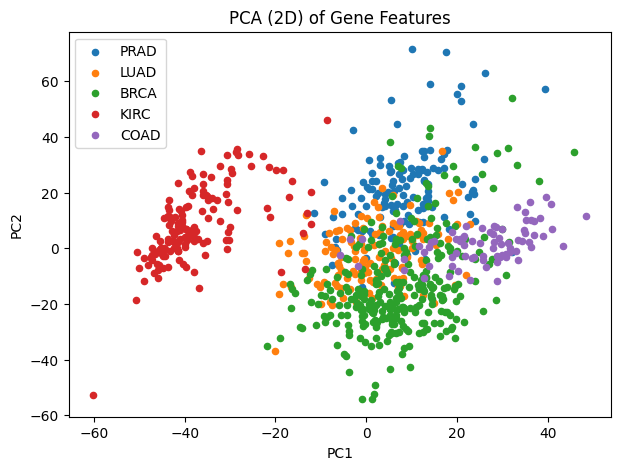

In [10]:
# pca visual
X = genetics.drop(columns=["cancer"])
y = genetics["cancer"]

X_scaled = StandardScaler().fit_transform(X)

Z = PCA(n_components=2).fit_transform(X_scaled)

plt.figure(figsize=(7,5))
for label in y.unique():
    idx = (y == label).values
    plt.scatter(Z[idx,0], Z[idx,1], label=label, s=20)

plt.title("PCA (2D) of Gene Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

# V. Discussion

## Conclusion

Overall, the model that I developed did extremely well at accurately classifying cancer type with genetic feature data. With feature selection, the model achieved perfect test accuracy with only a tiny fraction of the original number of features.

## Would this model be used in practice?

No, even though the performance was perfect with the data I used, I would not deploy this model without stronger testing. In the world of healthcare, the cost of being wrong is way too high and I'm sure there are things that could have been done to improve my model even further.

## Limitations + what I'd do next

The model was tested on just one dataset split, with only ~800 samples, which means it could have been sensitive to a lot of underlying factors like population differences, collection methods, etc. If I were to improve this model going forward, here are a few of the techniques that I would use:

* Cross-validation
* Choose certain genes for interpretability
* Have an actual doctor verify the model's decisions frequently


